In [1]:
import re
import string
import json
import os
import glob
import shutil
from pprint import pprint
from functools import partial

import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import sacremoses
from sklearn.base import clone
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
)


# Set Seaborn theme and default palette
sns.set_context("talk")
sns.set_theme(font_scale=1.25, style="whitegrid")
sns.set_palette("deep", desat=0.85, color_codes=True)

# Turn on inline plotting
%matplotlib inline

# Load Black auto-formatter
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Import my modules
from tools import cleaning, plotting, language as lang, outliers, utils
from tools.sklearn import selection

RUN_LANGDETECT = False

# Run time-consuming grid searches
RUN_SWEEPS = frozenset()

FIT_MODELS = frozenset({"svm_1", "svm_2", "svm_3"})

# Set my default MPL settings
plt.rcParams.update(plotting.MPL_DEFAULTS)

# Enable automatic reloading
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

# Business Problem

Amazon has asked me to build a product classifier for two purposes: (1) integrating new products into their classification scheme, and (2) flagging products which are probably misclassified. They requested that I make some recommendations related to product classification and its uses.

Accuracy is my highest priority, but I have a taste for interpretability and transparency, so the classifier I develop is sure to yield some insights about the data.

# Sourcing the Data

The Amazon product data I've chosen doesn't come directly from Amazon, but rather from three AI researchers, Jianmo Ni, Jiacheng Li, and Julian McAuley, who gathered it for their paper "Justifying Recommendations using Distantly-Labeled Reviews and Fine-grained Aspects." The review data extends from May 1996 to October 2018, which is about when they released the update. Their focus was primarily on reviews, but the dataset also has metadata for ~15-million products. The researchers don't say how they acquired the data, but judging from the HTML tags and chunks of JavaScript, they probably scraped it.

Since the full dataset is ~15M samples and ~13GB, I've created a separate notebook called `big_clean.ipynb` in which I download, reformat, and scrub the data until I'm left with ~4M samples. Despite the long and tortuous journey that is `big_clean.ipynb`, there's still much more to go.

# Preparing the Data

I begin by loading the data and doing a preliminary cleaning check.

In [3]:
df = pd.read_parquet(
    "data/amazon_clean",
    engine="pyarrow",
    columns=[
        "text",
        "title",
        "brand",
        "main_cat",
    ],
)

df

,text,title,brand,main_cat
asin,,,,
1441072241,come tell me how you lived: native american hi...,come tell me how you lived: native american hi...,enter the arena,all beauty
6090113980,prayer rug carpet mat gebetsteppich islamic mu...,prayer rug carpet mat gebetsteppich islamic mu...,bonballoon,all beauty
7250468162,no7 stay perfect foundation cool vanilla by no...,no7 stay perfect foundation cool vanilla by no7,no7,all beauty
8279996397,imagen bendita por su santidad our lady of cha...,imagen bendita por su santidad our lady of cha...,chango,all beauty
9197882747,hall of femmes: lella vignelli (hall of femmes...,hall of femmes: lella vignelli (hall of femmes),oyster press,all beauty
...,...,...,...,...
B01HHFHGES,xiaokong women's high low hem sleeveless flora...,xiaokong women's high low hem sleeveless flora...,xiaokong,books
B01HHX5AF2,duxa women's working my adipose off symbol gra...,duxa women's working my adipose off symbol gra...,duxa,books
B01HHZYKYW,aliixun2 unisex the 2016 rio de janeiro olympi...,aliixun2 unisex the 2016 rio de janeiro olympi...,aliixun2,books


<IPython.core.display.Javascript object>

In [4]:
cleaning.info(df)

,null,null_%,uniq,uniq_%,dup,dup_%
text,0,0.0,3692413,100.00,0,0.0
title,0,0.0,3672510,99.46,0,0.0
brand,0,0.0,818291,22.16,0,0.0
main_cat,0,0.0,36,0.00,0,0.0


<IPython.core.display.Javascript object>

No duplicates or nulls (at least ostensibly). Looks good.

Next I plot the main categories to get a sense of the balance.

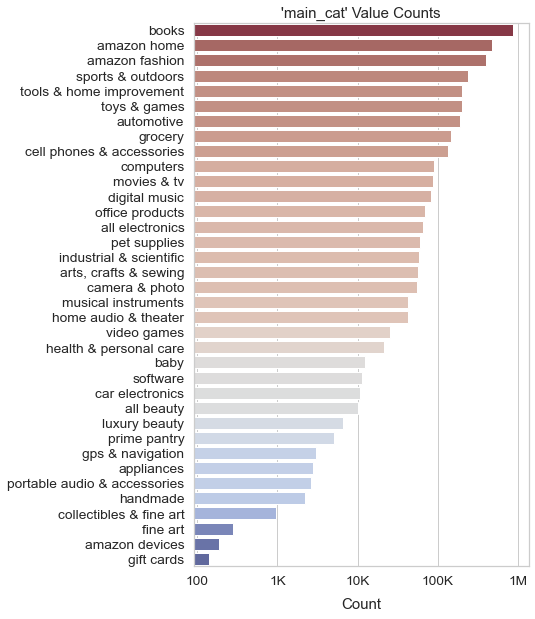

<IPython.core.display.Javascript object>

In [5]:
ax = plotting.plots.countplot(df.loc[:, "main_cat"], size=(6, 10), log_scale=True)
ax.xaxis.set_major_formatter(plotting.big_number_formatter())

The classes are very imbalanced, which is why I had to plot them on a logarithmic scale. Books are at the top.

## Refining the Brands

I begin with the brand terms, which will be very important for the classifier.

In [6]:
empty_brand = df.loc[df.brand.str.fullmatch("\s*")]
empty_brand

,text,title,brand,main_cat
asin,,,,
B000050B67,norelco 5655x deluxe advantage wet/dry cordles...,norelco 5655x deluxe advantage wet/dry cordles...,,all beauty
B000050B69,norelco t7500 deluxe cord/cordless rechargeabl...,norelco t7500 deluxe cord/cordless rechargeabl...,,all beauty
B000050FDP,braun 6520 flex integral ultra speed rechargea...,braun 6520 flex integral ultra speed rechargea...,,all beauty
B000052YD8,scope original mint mouthwash 50.7 fl oz. scop...,scope original mint mouthwash 50.7 fl oz,,all beauty
B00005336W,dove nutrium nutrient beads nourishing body wa...,dove nutrium nutrient beads nourishing body wa...,,all beauty
...,...,...,...,...
B01H0UDFXQ,marc lawrence's 2016 playbook football preview...,marc lawrence's 2016 playbook football preview,,books
B01H3U5GNA,american original soft and cozy coastal stripe...,american original soft and cozy coastal stripe...,,books
B01H87P6YM,hitachi 43in 2160p 120hz 4k uhd led tv. the ne...,hitachi 43in 2160p 120hz 4k uhd led tv,,books


<IPython.core.display.Javascript object>

Looks like there are over about 1.6 million empty brand entries. I'll replace those with 'none' for now.

In [7]:
df.loc[empty_brand.index, "brand"] = "none"
df.loc[df.brand.str.fullmatch("\s*")]

,text,title,brand,main_cat
asin,,,,


<IPython.core.display.Javascript object>

In [8]:
del empty_brand

<IPython.core.display.Javascript object>

Next, I'm going to tokenize the brands using the default Scikit-Learn tokenizer regex (r'\b\w\w+\b'). This is the default value for 'token_pattern' in `CountVectorizer`, `HashingVectorizer`, and `TfidfVectorizer`.

I like the default Scikit-Learn tokenizer because it ignores punctuation and grabs sequences of 2 or more word characters (within word boundaries). It strips out most of the noise in a single stroke.

I define a function below using this pattern.

In [9]:
def sklearn_tokenize(docs, n_jobs=None):
    pattern = re.compile(r"\b\w\w+\b")
    return lang.process_strings(docs, pattern.findall, n_jobs=n_jobs)

<IPython.core.display.Javascript object>

It's a short function, but a powerful one. It's **polymorphic**, meaning that it it behaves differently depending on the input type. If `docs` is a string, it simply returns the list of tokens. However, if `docs` is a container type like `Series` or `DataFrame`, it applies the tokenizer to every element. It also features **multiprocessing**, which can dramatically increase performance on large datasets.

Like many functions you'll see this notebook, it uses the infrastructure provided by my low-level function `lang.process_strings`.

In [10]:
help(lang.process_strings)

Help on function process_strings in module tools.language.utils:

process_strings(strings: Union[str, Iterable[str]], func: Callable[[str], Any], n_jobs: int = None, **kwargs) -> Any
    Apply `func` to a string or iterable of strings (elementwise).
    
    Most string filtering/processing functions in the language module
    are polymorphic, capable of handling either a single string or an
    iterable of strings. Whenever possible, they rely on this generic
    function to apply a callable to string(s). This allows them to
    behave polymorphically and take advantage of multiprocessing while
    having a simple implementation.
    
    This is a single dispatch generic function, meaning that it consists
    of multiple specialized sub-functions which each handle a different
    argument type. When called, the dispatcher checks the type of the first
    positional argument and then dispatches the sub-function registered
    for that type. In other words, when the function is called,

<IPython.core.display.Javascript object>

Another lower-level function you'll see is `lang.chain_processors`, which allows me to apply a function-pipeline to string(s). This is especially useful when I need to tokenize some strings, do something, and then detokenize them. In the following cell, I coerce the brand names to ASCII, tokenize them, and then immediately detokenize them. I want to reduce the number of unique values by reducing the number of near-duplicates.

In [11]:
# Function pipeline given as a list
steps = [lang.force_ascii, sklearn_tokenize, "_".join]

# Apply pipeline using all available cores
df["brand"] = lang.chain_processors(df.loc[:, "brand"], steps, n_jobs=-1)

df["brand"].value_counts()

none                   149124
generic                 10178
yu_gi_oh                 7075
magic_the_gathering      6488
nike                     5774
                        ...  
worm_eggs_and_more          1
power_wolf                  1
mrs_mary_pickens            1
james_tsai                  1
bocadecals_com              1
Name: brand, Length: 768552, dtype: int64

<IPython.core.display.Javascript object>

Over 790,000 unique brands! I'm going to use the brands as ngram phrases in the text, but I suspect most of these are too obscure to be useful. One-off brand terms are almost completely useless for a term-frequency-based classification, since they'll only appear in one vector.

In [12]:
def plot_brand_size_dist(data, brand_col="brand", bins=50, log_scale=True):
    brand_counts = data[brand_col].value_counts()
    g = sns.displot(
        data=brand_counts.to_frame(),
        x=brand_col,
        log_scale=log_scale,
        bins=bins,
        aspect=2,
    )
    g.axes[0, 0].set(
        xlabel="Product Count",
        ylabel="Number of Brands",
        title="Distribution of Brand Sizes (Product Count)",
    )
    g.axes[0, 0].yaxis.set_major_formatter(plotting.big_number_formatter())
    g.axes[0, 0].xaxis.set_major_formatter(plotting.big_number_formatter())

<IPython.core.display.Javascript object>

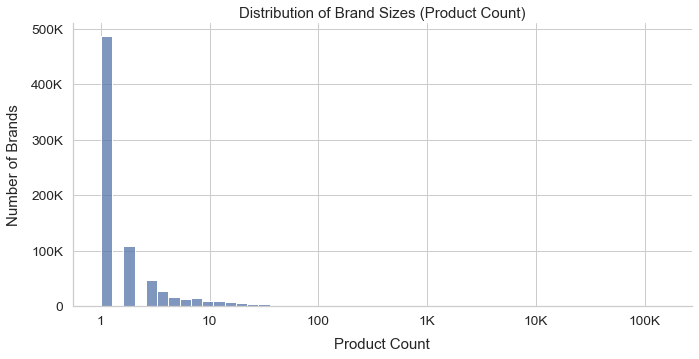

<IPython.core.display.Javascript object>

In [13]:
plot_brand_size_dist(df)

Over 500,000 brands have just one instance. I'm not interested in those.

In order to engineer a solid dataset for product classification, I'm going to keep only the biggest brands in each main category. That ought to get rid of most of the brand noise and make room for some signal.

For each main category, (with some exceptions) I keep only the top 1% of brands. Again, I'm measuring brand size in terms of number of products. Main categories with less than 1,000 samples are exempt from the pruning. Furthermore, all *none* entries will be dropped except in categories which are almost entirely *none* (in order to preserve the categories). The 'fine art' category, for instance, is ~99% *none*, presumably due to the unique nature of the products. Currently Amazon does show brands for fine art products, but that may have been different in 2018, when this data was collected.

In [14]:
# Drop brands below this quantile
qcut = 0.99

# Keep nulls if they dominate the category
null_dom_thresh = 0.95

# Don't prune small categories
protected_thresh = 1000

pruned_df = []

for cat, group in df.groupby("main_cat"):

    # Ignore small categories
    if len(group) <= protected_thresh:
        pruned_df.append(group)
        continue

    # Drop nulls if freq under `null_dom_thresh`
    brand_counts = group["brand"].value_counts(1)
    if brand_counts.get("none", 1.0) < null_dom_thresh:
        group = group.loc[group.brand != "none"]

    print(cat)
    print("-" * len(cat))

    # Drop brands below quantile `qcut`
    group = utils.prune_categories(group, "brand", qcut=qcut)

    print("\n")
    pruned_df.append(group)

pruned_df = pd.concat(pruned_df)

all beauty
----------
                            Status  Support
crystalage                retained       89
makingcosmetics           retained       80
kroo                      retained       67
crest                     retained       64
vktech                    retained       60
...                            ...      ...
bariani_olive_oil_compay   dropped        1
goody                      dropped        1
jenulence                  dropped        1
upper_canada_soap          dropped        1
dana                       dropped        1

[5177 rows x 2 columns]


all electronics
---------------
              Status  Support
sony        retained     1202
panasonic   retained     1137
samsung     retained      910
hp          retained      635
startech    retained      523
...              ...      ...
ebai         dropped        1
casr_store   dropped        1
hqt_906      dropped        1
hidgrow      dropped        1
dana         dropped        1

[12240 rows x 2 columns]


ama

[24660 rows x 2 columns]


handmade
--------
                         Status  Support
none                   retained     2212
unique                  dropped        6
marvel                  dropped        3
monster                 dropped        2
apple                   dropped        2
lego                    dropped        1
brenda_elaine_jewelry   dropped        1


health & personal care
----------------------
                        Status  Support
maxiaids              retained      139
liliane_memorials     retained      126
crystalage            retained      115
terravita             retained       89
big_dot_of_happiness  retained       88
...                        ...      ...
zrii                   dropped        1
tfi                    dropped        1
gu                     dropped        1
schott_sf_ht           dropped        1
testcountry            dropped        1

[10324 rows x 2 columns]


home audio & theater
--------------------
                  Status  Sup

<IPython.core.display.Javascript object>

In [15]:
size_reduct = 1 - (len(pruned_df) / len(df))
print(f"Reduced n_samples by {size_reduct:.0%}")
pruned_df

Reduced n_samples by 71%


,text,title,brand,main_cat
asin,,,,
B000050AUH,philips sonicare standard brush head. sonic wa...,philips sonicare standard brush head,philips_sonicare,all beauty
B000050B62,norelco 5841xl deluxe reflex action cord/cordl...,norelco 5841xl deluxe reflex action cord/cordl...,norelco,all beauty
B000050B63,norelco 6826xl quadra action cord/cordless rec...,norelco 6826xl quadra action cord/cordless rec...,norelco,all beauty
B000050B64,norelco 6865xl quadra action cord/cordless rec...,norelco 6865xl quadra action cord/cordless rec...,norelco,all beauty
B000050B65,norelco 6885xl deluxe quadra action cord/cordl...,norelco 6885xl deluxe quadra action cord/cordl...,norelco,all beauty
...,...,...,...,...
B01HH6JEOC,the sims 4 kids room stuff [online game code]....,the sims 4 kids room stuff [online game code],electronic_arts,video games
B01HIU43S4,1k games sega mega drive game console with wir...,1k games sega mega drive game console with wir...,sega,video games
B01HIZF83S,bioshock: the collection - playstation 4. retu...,bioshock: the collection - playstation 4,2k,video games


<IPython.core.display.Javascript object>

In [16]:
pruned_df.brand.nunique()

9117

<IPython.core.display.Javascript object>

This is an enormous dataset, so the top 1% of brands in each category leaves me with ~9k brands. That's a fairly large, yet manageable, number.

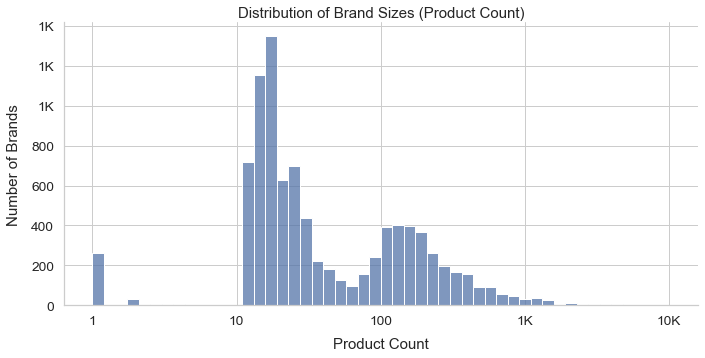

<IPython.core.display.Javascript object>

In [17]:
plot_brand_size_dist(pruned_df)

Although I only took the top 1% of brands in each category, most of the brands have 10-50 products. That seems like a healthy number.

The histogram also shows that there are ~400 single-product brands from the protected categories. That's fine. Those terms won't be very useful, but there's plenty of other useful information in those categories.

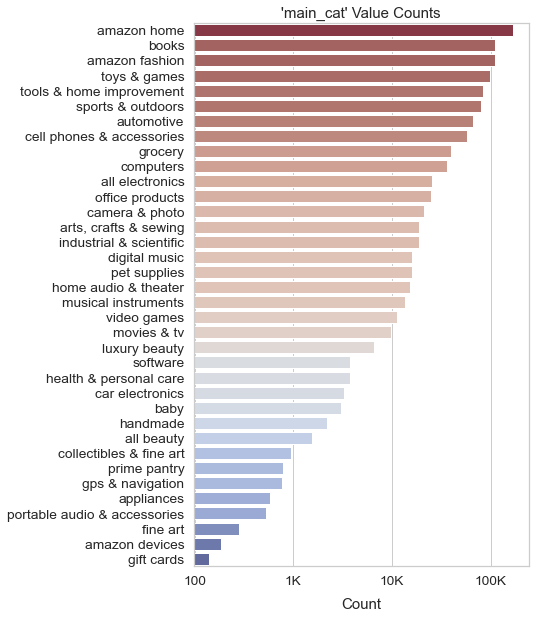

<IPython.core.display.Javascript object>

In [18]:
ax = plotting.plots.countplot(
    pruned_df.loc[:, "main_cat"], log_scale=True, size=(6, 10)
)
ax.xaxis.set_major_formatter(plotting.big_number_formatter())

In [19]:
df = pruned_df
df.head()

,text,title,brand,main_cat
asin,,,,
B000050AUH,philips sonicare standard brush head. sonic wa...,philips sonicare standard brush head,philips_sonicare,all beauty
B000050B62,norelco 5841xl deluxe reflex action cord/cordl...,norelco 5841xl deluxe reflex action cord/cordl...,norelco,all beauty
B000050B63,norelco 6826xl quadra action cord/cordless rec...,norelco 6826xl quadra action cord/cordless rec...,norelco,all beauty
B000050B64,norelco 6865xl quadra action cord/cordless rec...,norelco 6865xl quadra action cord/cordless rec...,norelco,all beauty
B000050B65,norelco 6885xl deluxe quadra action cord/cordl...,norelco 6885xl deluxe quadra action cord/cordl...,norelco,all beauty


<IPython.core.display.Javascript object>

I check the brands of 'arts, crafts, & sewing' as a basic sanity check.

In [20]:
df.groupby("main_cat").get_group("arts, crafts & sewing").brand.value_counts()

lantern_press               1030
3drose                       829
beadaholique                 795
sizzix                       696
spellbinders                 597
                            ... 
moda                          86
unique_wood_shapes            85
crafter_companion             85
vogue_fabrics                 83
sparkles_make_it_special      82
Name: brand, Length: 96, dtype: int64

<IPython.core.display.Javascript object>

Seems to be a healthy number.

## Engineering the Vocabulary

I engineer the model's vocabulary by preprocessing the text, developing a custom tokenizer, and constructing multi-word expressions. The purpose of the model is to assimilate novel products into Amazon's existing classification scheme. If the vocabulary is to serve that purpose, it will require some *a priori* decision-making.

To be clear, I don't intend to feed `TfidfVectorizer` a fixed vocabulary, because that would restrict my ability to tune the vocabulary later on. I plan on letting the vectorizer learn the vocabulary on its own, but I want it to learn the *right* vocabulary.

Before making any decisions, I define a function for creating a vocabulary from a sample of the corpus.

In [21]:
def build_sample_vocab(
    corpus,
    n_docs,
    *,
    tokenizer=None,
    sortby="length",
    random_state=363,
    n_jobs=-1,
):
    # Get sample of corpus
    if n_docs is None:
        samp_corpus = corpus
    else:
        samp_corpus = corpus.sample(n_docs, random_state=random_state)

    # Tokenize
    if tokenizer is None:
        # Check if already tokenized
        if not pd.api.types.is_list_like(corpus.iloc[0]):
            # Space tokenize if necessary
            samp_corpus = lang.space_tokenize(samp_corpus, n_jobs=n_jobs)
    else:
        samp_corpus = lang.process_strings(samp_corpus, tokenizer, n_jobs=n_jobs)

    # Build vocabulary
    vocab = samp_corpus.explode().value_counts()
    vocab = vocab.reset_index(name="freq").rename(columns={"index": "term"})

    # Add additional stats
    vocab["length"] = vocab.loc[:, "term"].str.len()
    vocab["uniq_ratio"] = vocab.loc[:, "term"].map(lang.uniq_ratio)

    return vocab.sort_values(sortby, ascending=False)

<IPython.core.display.Javascript object>

### Optimize the Tokenizer?

There are many tokenizers on the market. Shouldn't I grid-search over them all to maximize my accuracy score?

No. The choice of tokenizer requires some *human* intelligence. The purpose of the model is to classify new products into Amazon's existing categories. High test scores do not always indicate a better model&mdash;sometimes, they reflect overfitting.

Take for example `nltk.wordpunct_tokenize`. This tokenizer captures arbitrarily long sequences of punctuation in addition to normal words.

In [22]:
# Get small sample of corpus
wordpunct_vocab = build_sample_vocab(
    df.loc[:, "text"], 10 ** 4, tokenizer=nltk.wordpunct_tokenize
)

# Slice out some punctuation
wordpunct_vocab.loc[wordpunct_vocab.term.str.startswith("!"), "term"].head(10)

21186    !~~~~~~~~~~~~~~~~~
67047     !!!**************
42249         !!!!~~~~~~~~~
60823              !!~~~~~~
57778              !!!!!!!.
51747               !!!~~~~
61373               !!!!!!!
46380               !!!!!!.
67523                !!!!!.
68639                 !!!),
Name: term, dtype: object

<IPython.core.display.Javascript object>

In [23]:
del wordpunct_vocab

<IPython.core.display.Javascript object>

 The problem is that these sequences are *artifacts* of this particular dataset. Suppose that the model learns to associate '#############' with the 'automotive' category and '&&&&&&&&!?!?!?' with 'baby'. That might be a real pattern in this particular dataset, but it's useless in general.

I begin with the the Scikit-Learn default tokenizer that I used on the brands. It captures sequences of two or more alphanumeric characters within a word boundary. It ignores punctuation and single letters, which results in very clean tokens. For example, 'Frank's' becomes 'Frank'. It's also lightning fast because it's just a regular expression.

In [24]:
# Get small sample of corpus
sklearn_vocab = build_sample_vocab(
    df.loc[:, "text"], 10 ** 4, tokenizer=sklearn_tokenize
)
sklearn_vocab.sort_values("length", ascending=False, inplace=True)

# Slice out numeric strings, sort by length
sklearn_vocab.loc[sklearn_vocab.term.str.isnumeric(), "term"].head(10)

55721    1751841921932592802854474645555585856556566571250
67512                    125112522450265229212825921906579
61858                                    00091352603400000
37537                                       32632405011001
42351                                        4051771122824
21850                                        7636490013904
57276                                        4051771494686
47164                                        0679420370927
56214                                        0632059928570
61237                                        4543112931344
Name: term, dtype: object

<IPython.core.display.Javascript object>

In [25]:
del sklearn_vocab

<IPython.core.display.Javascript object>

One problem with the Scikit-Learn tokenizer is that it produces code-like numeric sequences. My goal is not to create a model which picks up on ultra-rare ID numbers and codes for specific products, but to create a model which recognizes broad patterns in **natural language**.

I define my own tokenizer in the cell below.

In [26]:
def my_tokenize(docs, n_jobs=None):
    pattern = re.compile(r"(?i)\b[a-z_]{2,}\b")
    return lang.process_strings(docs, pattern.findall, n_jobs=n_jobs)

<IPython.core.display.Javascript object>

The tokenizer I created above captures sequences of two or more alphabetic ASCII characters (plus underscore) `'[a-z_]{2,}'` within word boundaries `'\b'` while ignoring case `(?i)`. It ignores non-ASCII characters including accented letters, which I deliberately conflate with their non-accented counterparts.

In [27]:
df["text"] = lang.force_ascii(df.loc[:, "text"], n_jobs=-1)
df["text"].head()

asin
B000050AUH    philips sonicare standard brush head. sonic wa...
B000050B62    norelco 5841xl deluxe reflex action cord/cordl...
B000050B63    norelco 6826xl quadra action cord/cordless rec...
B000050B64    norelco 6865xl quadra action cord/cordless rec...
B000050B65    norelco 6885xl deluxe quadra action cord/cordl...
Name: text, dtype: object

<IPython.core.display.Javascript object>

One thing my tokenizer doesn't address is tokens that are too long.

In [28]:
samp_vocab = build_sample_vocab(df.loc[:, "text"], 10 ** 4, tokenizer=my_tokenize)

samp_vocab.head(10)

,term,freq,length,uniq_ratio
49956,thebuildinkickstandcanbeusedinlandscapeorienta...,1,72,0.250000
47050,______________________________________________...,1,62,0.016129
39897,withbeltclipholstersoyoucancarrythedevicewhere...,1,54,0.351852
46684,_______________________________________,1,39,0.025641
38655,brighterthannormalstocklightbulbs,1,33,0.484848
43735,specificationspecificationfeature,1,33,0.363636
41142,floorlinerdigitalfitaccurately,1,30,0.466667
17787,whiteracingproductsllc_nossee,5,29,0.586207
47564,the_strictly_mint_card_co_inc,1,29,0.517241
45130,thelavenderperfumedsachetis,1,27,0.592593


<IPython.core.display.Javascript object>

As you can see, most of these 20+ character strings are just idiosyncratic noise. Take for example the term 'sherryguzzlinggranny':

In [29]:
granny_book = df.loc[df.text.str.contains("sherryguzzlinggranny")].iloc[0]
display(granny_book)
granny_book.text

text        queen of babble gets hitched. when last seen, ...
title                            queen of babble gets hitched
brand                                               meg_cabot
main_cat                                                books
Name: 006085202X, dtype: object

"queen of babble gets hitched. when last seen, the irrepressible lizzie nichols was canoodling with chaz after she and luke, chaz's best friend, broke up ( queen of babble in the big city , 2007). nowshocker alertluke returns to new york and slips a three-carat diamond engagement ring on her finger. lizzie accepts even though she's still all googly over chaz, who bluntly warns lizzie that luke's all about luke and couldn't love her the way he does. lizzie, a wedding dress restorer and budding designer specializing in wedding garb, faces a hives-inducing decision: dump rich luke, who wants to be an investment banker in paris, and hook up with chaz, who wants to teach? or should she marry luke and ditch new york for paris? and then there's the matter of her burgeoning design business, helped along by ava geck, a paris hiltonlike celebrity heiress. cabot takes full advantage of the material, delivering her trademark wit, sharp banter and lively antics from the first page. fans of the seri

<IPython.core.display.Javascript object>

The term 'sherryguzzlinggranny' comes from the book *Queen of Babble Gets Hitched*. The description (above) contains a number of similar typos, such as 'lizziesbad-mouthed', 'high-strungassistant', and 'amusingreaders'. I have no qualms about filtering these out.

I also notice that there are long sequences containing underscores. I'm not interested in any of the underscores already in the data, only ones that I might add. I'll filter those out immediately.

In [30]:
df["text"] = lang.strip_punct(df.loc[:, "text"], n_jobs=-1)
df["text"].str.contains("_").any()

False

<IPython.core.display.Javascript object>

Next I get a larger sample and examine the length distribution.

In [31]:
samp_vocab = build_sample_vocab(df.loc[:, "text"], 10 ** 5, tokenizer=my_tokenize)

samp_vocab.sample(10)

,term,freq,length,uniq_ratio
25874,jigging,23,7,0.571429
126609,bronzekelston,1,13,0.769231
147424,synthphony,1,10,0.700000
43765,sways,7,5,0.800000
77254,waterfowler,2,11,0.727273
15397,fostering,67,9,1.000000
145124,descendmode,1,11,0.636364
16270,plotted,60,7,0.857143
7465,possibility,230,11,0.727273
55100,ceramiczne,4,10,0.800000


<IPython.core.display.Javascript object>

Next I examine the length distribution to determine a good cutoff point for length outliers. The plot is annotated with the IQR and Tukey's fences (i.e. boxplot whiskers).

<AxesSubplot:xlabel='length', ylabel='Count'>

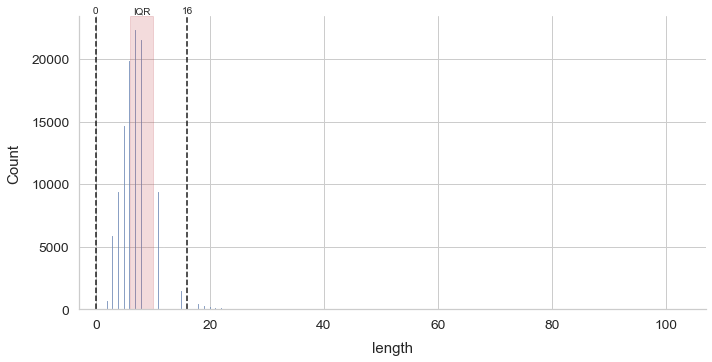

<IPython.core.display.Javascript object>

In [32]:
g = sns.displot(data=samp_vocab, x="length", kind="hist", aspect=2)
plotting.add_tukey_marks(samp_vocab["length"], g.axes[0, 0], num_format=".0f")

16 seems like a natural cutoff for word length, and it's what Tukey's IQR proximity rule dictates. Rather than enforce this cutoff with my tokenizer, I'll filter the tokens independently. That way I can construct longer multi-word expressions later.

In [33]:
# Tokenize
df["text"] = my_tokenize(df.loc[:, "text"], n_jobs=-1)
df["text"].head()

asin
B000050AUH    [philips, sonicare, standard, brush, head, son...
B000050B62    [norelco, deluxe, reflex, action, cord, cordle...
B000050B63    [norelco, quadra, action, cord, cordless, rech...
B000050B64    [norelco, quadra, action, cord, cordless, rech...
B000050B65    [norelco, deluxe, quadra, action, cord, cordle...
Name: text, dtype: object

<IPython.core.display.Javascript object>

In [34]:
# Filter out long
df["text"] = lang.length_filter(df.loc[:, "text"], max_char=16, n_jobs=-1)
df["text"]

asin
B000050AUH    [philips, sonicare, standard, brush, head, son...
B000050B62    [norelco, deluxe, reflex, action, cord, cordle...
B000050B63    [norelco, quadra, action, cord, cordless, rech...
B000050B64    [norelco, quadra, action, cord, cordless, rech...
B000050B65    [norelco, deluxe, quadra, action, cord, cordle...
                                    ...                        
B01HH6JEOC    [the, sims, kids, room, stuff, online, game, c...
B01HIU43S4    [games, sega, mega, drive, game, console, with...
B01HIZF83S    [bioshock, the, collection, playstation, retur...
B01HJ149LI    [god, eater, resurrection, ps, vita, digital, ...
B01HJ14FDA    [jojo, eyes, of, heaven, complete, bundle, dig...
Name: text, Length: 1072953, dtype: object

<IPython.core.display.Javascript object>

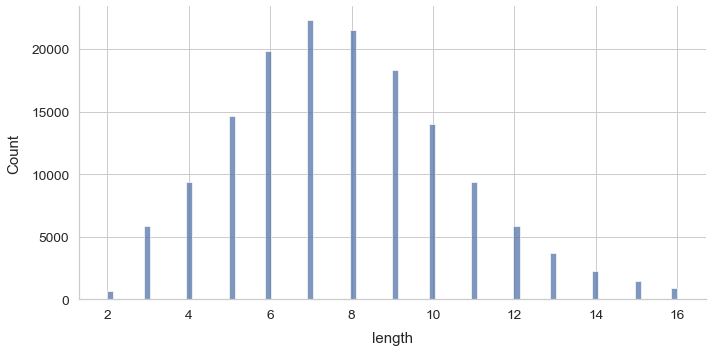

<IPython.core.display.Javascript object>

In [35]:
# Draw new sample
samp_vocab = build_sample_vocab(df.loc[:, "text"], 10 ** 5)

# Plot length distribution
g = sns.displot(data=samp_vocab, x="length", kind="hist", aspect=2)

A related source of noise are strings with repetitive character (or word) sequences.

In [36]:
samp_vocab.sort_values("uniq_ratio").head(10)

,term,freq,length,uniq_ratio
135236,zzzzzzzz,1,8,0.125000
141344,ffffff,1,6,0.166667
136546,xxxxx,1,5,0.200000
140404,noooooooo,1,9,0.222222
45404,xxxx,7,4,0.250000
135980,iiii,1,4,0.250000
39269,aaaa,9,4,0.250000
125729,oraoraoraora,1,12,0.250000
136434,mmmm,1,4,0.250000
102901,cccc,1,4,0.250000


<IPython.core.display.Javascript object>

The above terms with repetitive sequences have low character uniqueness ratios, i.e. the ratio of character types to character tokens. That's how I'll filter them out.

Note: long multi-word amalgamations also have low character uniqueness simply because of their length, but I've already weeded those out.

<AxesSubplot:xlabel='uniq_ratio', ylabel='Count'>

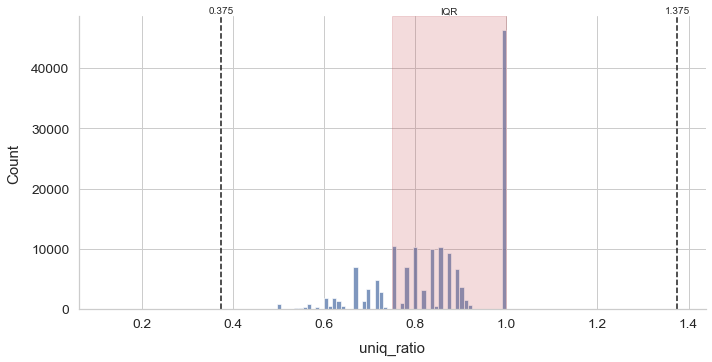

<IPython.core.display.Javascript object>

In [37]:
g = sns.displot(data=samp_vocab, x="uniq_ratio", kind="hist", aspect=2)
plotting.add_tukey_marks(samp_vocab["uniq_ratio"], g.axes[0, 0], num_format=".3f")

The lower Tukey fence is located at 0.375. That seems like a reasonable cutoff.

In [38]:
# Remove low uniqueness ratios
df["text"] = lang.uniq_char_thresh(df.loc[:, "text"], thresh=0.375, n_jobs=-1)
df["text"].head()

asin
B000050AUH    [philips, sonicare, standard, brush, head, son...
B000050B62    [norelco, deluxe, reflex, action, cord, cordle...
B000050B63    [norelco, quadra, action, cord, cordless, rech...
B000050B64    [norelco, quadra, action, cord, cordless, rech...
B000050B65    [norelco, deluxe, quadra, action, cord, cordle...
Name: text, dtype: object

<IPython.core.display.Javascript object>

In [39]:
samp_vocab = build_sample_vocab(df.loc[:, "text"], 10 ** 5)
samp_vocab.sort_values("uniq_ratio").head(10)

,term,freq,length,uniq_ratio
136241,mirrormirrors,1,13,0.384615
144404,eminentemente,1,13,0.384615
36830,reengineering,11,13,0.384615
54191,xxxxl,5,5,0.400000
134253,tennessees,1,10,0.400000
107830,arrrr,1,5,0.400000
76593,woooo,2,5,0.400000
82838,sassafrass,2,10,0.400000
86308,tatta,2,5,0.400000
5740,sleeveless,349,10,0.400000


<IPython.core.display.Javascript object>

Looks better. If I raise the threshold more, I'll begin to filter out too many normal words.

## Restricting to English

Next I run [langdetect](https://pypi.org/project/langdetect/) (a Google language detection algorithm) on the documents and select only the English product descriptions. I have nothing against the other languages, but there are not enough examples of them in the dataset to build a truly multilingual model. I don't want the model to associate Spanish words with 'amazon fashion', for example. That would generalize poorly.

This cell takes 30-40 minutes to run if `RUN_LANGDETECT` is set.

In [40]:
if RUN_LANGDETECT:
    # Wrapper of `langdetect.detect` with multiprocessing
    df["lang"] = lang.detect_lang(df.loc[:, "text"].str.join(" "), seed=0, n_jobs=-1)
    df["lang"].to_json("data/langdetect.json")
else:
    df["lang"] = pd.read_json("data/langdetect.json", typ="series")

    # Run on missing
    missing = df["lang"].isna()
    if missing.any():
        df.loc[missing, "lang"] = lang.detect_lang(
            df.loc[missing, "text"].str.join(" "),
            seed=51,
            n_jobs=-1,
        )
        # Save new results
        df["lang"].to_json("data/langdetect.json")

df["lang"].value_counts()

en    1070668
es        988
it        200
fr        200
pt        133
no        117
nl        116
de        112
da         84
id         56
ca         49
sv         39
af         29
ro         25
pl         22
so         19
tl         12
sl         12
hr         10
sw         10
cs         10
lt          9
et          7
cy          7
hu          5
tr          5
fi          3
sk          2
sq          2
lv          1
vi          1
Name: lang, dtype: int64

<IPython.core.display.Javascript object>

In [41]:
df = df.loc[df.lang == "en"]
df["lang"].value_counts()

en    1070668
Name: lang, dtype: int64

<IPython.core.display.Javascript object>

In [42]:
len(df)

1070668

<IPython.core.display.Javascript object>

## Removing Stopwords

Before searching for collocations, I want to remove stopwords. As you can see below, there are quite a few in the vocabulary.

In [43]:
samp_vocab = build_sample_vocab(df.loc[:, "text"], 10 ** 4, sortby="freq")
samp_vocab.head(10)

,term,freq,length,uniq_ratio
0,the,73153,3,1.0
1,and,67136,3,1.0
2,to,39298,2,1.0
3,of,36294,2,1.0
4,for,28180,3,1.0
5,with,26574,4,1.0
6,in,25908,2,1.0
7,is,21422,2,1.0
8,your,14475,4,1.0
9,this,12789,4,1.0


<IPython.core.display.Javascript object>

In [44]:
# Fetch stopwords
stop = lang.fetch_stopwords("nltk_english")
# Run through tokenizer
stop = {y for x in stop for y in my_tokenize(x)}
# Make sure there are no brand terms
stop = stop.difference(df["brand"])
pprint(stop, compact=True)

{'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and',
 'any', 'are', 'aren', 'as', 'be', 'because', 'been', 'before', 'being',
 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', 'did', 'didn', 'do',
 'does', 'doesn', 'doing', 'don', 'down', 'during', 'each', 'few', 'for',
 'from', 'further', 'had', 'hadn', 'has', 'hasn', 'have', 'haven', 'having',
 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'if',
 'in', 'into', 'is', 'isn', 'it', 'its', 'itself', 'just', 'll', 'ma', 'me',
 'mightn', 'more', 'most', 'mustn', 'my', 'myself', 'needn', 'no', 'nor', 'not',
 'now', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours',
 'ourselves', 'out', 'over', 'own', 're', 'same', 'shan', 'she', 'should',
 'shouldn', 'so', 'some', 'such', 'than', 'that', 'the', 'their', 'theirs',
 'them', 'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
 'through', 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was', 'wasn',
 '

<IPython.core.display.Javascript object>

I add some more domain-specific stopwords.

In [120]:
more_stop = [
    "none",
    "inches",
    "shipping",
    "shipped",
    "shipper",
    "shipments",
    "package",
    "product",
    "weight",
    "pounds",
    "ounces",
    "dimensions",
    "asin",
    "item",
    "listed",
    "within",
    "apo",
    "fpo",
    "address",
    "addresses",
    "support",
    "eligible",
    "customer",
    "review",
    "reviews",
    "reviewer",
    "reviewed",
]
stop.update({y for x in more_stop for y in my_tokenize(x)})
pprint(stop, compact=True)

{'about', 'above', 'address', 'addresses', 'after', 'again', 'against', 'ain',
 'all', 'am', 'an', 'and', 'any', 'apo', 'are', 'aren', 'as', 'asin', 'be',
 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by',
 'can', 'couldn', 'customer', 'did', 'didn', 'dimensions', 'do', 'does',
 'doesn', 'doing', 'don', 'down', 'during', 'each', 'eligible', 'few', 'for',
 'fpo', 'from', 'further', 'had', 'hadn', 'has', 'hasn', 'have', 'haven',
 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his',
 'how', 'if', 'in', 'inches', 'into', 'is', 'isn', 'it', 'item', 'item_number',
 'its', 'itself', 'just', 'listed', 'll', 'ma', 'me', 'mightn', 'model_number',
 'more', 'most', 'mustn', 'my', 'myself', 'needn', 'no', 'none', 'nor', 'not',
 'now', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ounces', 'our',
 'ours', 'ourselves', 'out', 'over', 'own', 'package', 'pounds', 'product',
 're', 'review', 'reviewed', 'reviewer', 'reviews', 'same', 'shan', 'she',

<IPython.core.display.Javascript object>

In [46]:
samp_vocab = build_sample_vocab(df["text"], 10 ** 4, sortby="freq")
samp_vocab.head(10)

,term,freq,length,uniq_ratio
0,the,73153,3,1.0
1,and,67136,3,1.0
2,to,39298,2,1.0
3,of,36294,2,1.0
4,for,28180,3,1.0
5,with,26574,4,1.0
6,in,25908,2,1.0
7,is,21422,2,1.0
8,your,14475,4,1.0
9,this,12789,4,1.0


<IPython.core.display.Javascript object>

In [47]:
# functools.partial wraps the func and holds `stop` in place
remove_my_stop = partial(lang.remove_stopwords, stopwords=stop)

df = df.assign(text=df.loc[:, "text"].map(remove_my_stop))
df["text"].head()

asin
B000050AUH    [philips, sonicare, standard, brush, head, son...
B000050B62    [norelco, deluxe, reflex, action, cord, cordle...
B000050B63    [norelco, quadra, action, cord, cordless, rech...
B000050B64    [norelco, quadra, action, cord, cordless, rech...
B000050B65    [norelco, deluxe, quadra, action, cord, cordle...
Name: text, dtype: object

<IPython.core.display.Javascript object>

## Multi-word Expressions

I already have a lot of high quality brand phrases which I expect to be strong features for the model. I'll go ahead and prepare those.

In [48]:
brand_ng = df.loc[:, "brand"].drop_duplicates().str.split("_").map(tuple)
brand_ng = brand_ng.loc[brand_ng.map(len) > 1]
brand_ng

asin
B000050AUH               (philips, sonicare)
B000050B6B                (philips, norelco)
B0000531WK                    (oreal, paris)
B0000532QF                  (tom, of, maine)
B000066SYD                     (aqua, fresh)
                           ...              
B00008YGO2                    (mumbo, jumbo)
B000ASBKGA                    (cta, digital)
B0017IK8W4                    (deep, silver)
B001K7HUUK           (alawar, entertainment)
B00GQVGV9Q    (big, leap, studios, pvt, ltd)
Name: brand, Length: 6781, dtype: object

<IPython.core.display.Javascript object>

I search for collocations in the text in a stratified fashion, scanning the documents of each 'main_cat' category as a separate corpus. The goal is to find ngrams which are peculiar to each category. I use pointwise mutual information (PMI) to identify bigrams.

In [50]:
cat_bg = lang.stratified_ngrams(
    # Join tokens back together
    df.assign(text=df.loc[:, "text"].str.join(" ")),
    n=2,
    text="text",
    # Stratify by 'main_cat'
    cat="main_cat",
    tokenizer=my_tokenize,
    # Use pointwise mutual information
    metric="pmi",
    # Select top 75% of scores in each category
    select_best=0.75,
    # Filter out ultra-rare ngrams
    min_freq=100,
    n_jobs=-1,
)
cat_bg

,bigram,score,main_cat
0,"(year, warranty)",9.750503,all beauty
1,"(tom, maine)",9.687209,all beauty
2,"(old, spice)",9.514352,all beauty
3,"(diamond, fx)",9.006641,all beauty
4,"(pro, health)",8.985854,all beauty
...,...,...,...
114997,"(multiplayer, mode)",4.928163,video games
114998,"(additional, features)",4.928119,video games
114999,"(gives, players)",4.893252,video games
115000,"(xbox, account)",4.890853,video games


<IPython.core.display.Javascript object>

In [51]:
# Merge ngrams into single list
phrases = cat_bg.bigram.append(brand_ng).drop_duplicates().to_list()
display(len(phrases))
phrases[:10]

99195

[('year', 'warranty'),
 ('tom', 'maine'),
 ('old', 'spice'),
 ('diamond', 'fx'),
 ('pro', 'health'),
 ('face', 'paint'),
 ('philips', 'sonicare'),
 ('philips', 'norelco'),
 ('brand', 'new'),
 ('high', 'quality')]

<IPython.core.display.Javascript object>

In [52]:
ngram_tokenize = nltk.MWETokenizer(phrases).tokenize
ngram_tokenize

<bound method MWETokenizer.tokenize of <nltk.tokenize.mwe.MWETokenizer object at 0x0000027A67EEFF10>>

<IPython.core.display.Javascript object>

In [53]:
df["text"] = df.loc[:, "text"].map(ngram_tokenize)

df["text"].head()

asin
B000050AUH    [philips_sonicare, standard, brush_head, sonic...
B000050B62    [norelco, deluxe, reflex, action, cord, cordle...
B000050B63    [norelco, quadra, action, cord, cordless, rech...
B000050B64    [norelco, quadra, action, cord, cordless, rech...
B000050B65    [norelco, deluxe, quadra, action, cord, cordle...
Name: text, dtype: object

<IPython.core.display.Javascript object>

In [54]:
df["text"] = df.loc[:, "text"].str.join(" ")
df["text"].head()

asin
B000050AUH    philips_sonicare standard brush_head sonic wav...
B000050B62    norelco deluxe reflex action cord cordless rec...
B000050B63    norelco quadra action cord cordless rechargeab...
B000050B64    norelco quadra action cord cordless rechargeab...
B000050B65    norelco deluxe quadra action cord cordless rec...
Name: text, dtype: object

<IPython.core.display.Javascript object>

In [55]:
if os.path.exists("data/model_data"):
    shutil.rmtree("data/model_data")

df.to_parquet(
    "data/model_data",
    engine="pyarrow",
    index=True,
    partition_cols="main_cat",
)

<IPython.core.display.Javascript object>

Before I move on to modeling, I plot the final class balance.

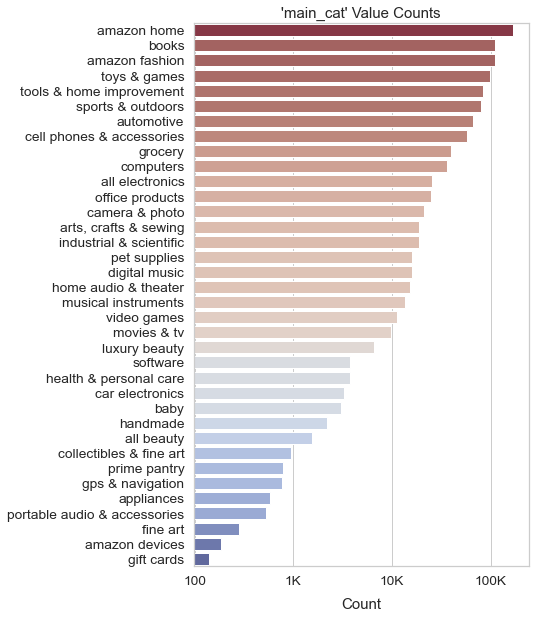

<IPython.core.display.Javascript object>

In [56]:
ax = plotting.plots.countplot(df.loc[:, "main_cat"], size=(6, 10), log_scale=True)
ax.xaxis.set_major_formatter(plotting.big_number_formatter())
ax.figure.savefig(
    "figures/class_bal.svg",
    bbox_inches="tight",
)


# Modeling
## Performing the Split

In [92]:
df = pd.read_parquet("data/model_data", engine="pyarrow")
df.head()

,text,title,brand,lang,main_cat
asin,,,,,
B000050AUH,philips_sonicare standard brush_head sonic wav...,philips sonicare standard brush head,philips_sonicare,en,all beauty
B000050B62,norelco deluxe reflex action cord cordless rec...,norelco 5841xl deluxe reflex action cord/cordl...,norelco,en,all beauty
B000050B63,norelco quadra action cord cordless rechargeab...,norelco 6826xl quadra action cord/cordless rec...,norelco,en,all beauty
B000050B64,norelco quadra action cord cordless rechargeab...,norelco 6865xl quadra action cord/cordless rec...,norelco,en,all beauty
B000050B65,norelco deluxe quadra action cord cordless rec...,norelco 6885xl deluxe quadra action cord/cordl...,norelco,en,all beauty


<IPython.core.display.Javascript object>

In [93]:
X = df.loc[:, "text"]
y = df.loc[:, "main_cat"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=49, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((803001,), (267667,), (803001,), (267667,))

<IPython.core.display.Javascript object>

Next, I create the vectorizer. I have a taste for interpretability and transparency, which is why I've opted to use term-frequency vectorization (e.g. binary occurrence, raw term-frequency, or TF\*IDF). For the baseline model, I turn off IDF weighting and normalization. Therefore, `tf` is initially set to extract raw term-frequency vectors from the text.

In [94]:
tf = TfidfVectorizer(
    lowercase=False,
    token_pattern=r"(?i)\b[a-z_]{2,}\b",
    norm=None,
    use_idf=False,
)

tf

TfidfVectorizer(lowercase=False, norm=None,
                token_pattern='(?i)\\b[a-z_]{2,}\\b', use_idf=False)

<IPython.core.display.Javascript object>

I've opted to use Scikit-Learn's `SGDClassifier` because it's efficient on large datasets and works with several different loss functions. Essentially, it offers widely used linear classifiers with stochastic gradient descent optimization.

I could have also chosen a neural network classifier such as Scikit-Learn's ready-made multi-layer perceptron. However, neural networks take a long time to train and are the least interpretable algorithms on the market. For this project, given my limited computational resources and personal tastes, I've opted for a more traditional approach.

In [95]:
sgd = SGDClassifier(
    loss="hinge",
    class_weight="balanced",
    n_jobs=-1,
)

sgd

SGDClassifier(class_weight='balanced', n_jobs=-1)

<IPython.core.display.Javascript object>

The default loss function 'hinge' is a linear support vector classifier. `SGDClassifier` also offers squared hinge, logistic regression, modified Huber, and several losses designed for regression.

Next, I create a pipeline containing just two steps: the vectorizer and the classifier.

In [96]:
pipe = Pipeline(
    [
        ("vec", tf),
        ("cls", sgd),
    ],
    verbose=True,
)
pipe

Pipeline(steps=[('vec',
                 TfidfVectorizer(lowercase=False, norm=None,
                                 token_pattern='(?i)\\b[a-z_]{2,}\\b',
                                 use_idf=False)),
                ('cls', SGDClassifier(class_weight='balanced', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

The [User Guide](https://scikit-learn.org/stable/modules/sgd.html#sgd) emphasizes that `SGDClassifier` is sensitive to feature scale. However, since word frequencies are already on the same scale, there is no need to include a scaler.

A related concern is vector normalization (sample scale). The User Guide states that the default learning rate formula (`learning_rate='optimal'`) assumes "that the norm of the training samples is approx. 1." Another reason to normalize the vectors is to minimize the effect of document length. Again, I've turned it off for the baseline, but I fully expect to turn it back on later.

Next I define some functions which I'll use throughout the modeling process.

In [97]:
def plot_confusion_matrix(
    estimator,
    X_test=X_test,
    y_test=y_test,
    dst=None,
    xticks_rotation="vertical",
    **kwargs,
):
    """Plots confusion matrix with accuracy score."""
    ax = plotting.confusion_matrix(
        estimator,
        X_test,
        y_test,
        xticks_rotation=xticks_rotation,
        **kwargs,
    )
    y_pred = estimator.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    ax.set_title(f"Accuracy: {acc:.2f}, Balanced Accuracy: {bal_acc:.2f}", pad=5)
    if isinstance(dst, str):
        plt.savefig(dst, bbox_inches="tight")
    return ax

<IPython.core.display.Javascript object>

In [98]:
def get_report(estimator, X_test=X_test, y_test=y_test):
    """Returns standard classification metrics as a DataFrame."""
    report = classification_report(y_test, estimator.predict(X_test), output_dict=True)
    report = pd.DataFrame(report).T
    report.loc["accuracy", "support"] = report["support"].max()
    return report

<IPython.core.display.Javascript object>

In [99]:
def extract_coef(
    pipeline,
    classifier="cls",
    vectorizer="vec",
):
    """Returns labeled model coefficients as a DataFrame."""
    columns = np.array(pipeline[vectorizer].get_feature_names())
    coef = pd.DataFrame(
        pipeline[classifier].coef_,
        index=pipeline[classifier].classes_,
        columns=columns,
    ).T
    return coef

<IPython.core.display.Javascript object>

## Fitting the Baseline

Without further ado, it's time to fit the baseline model.

In [100]:
if "svm_1" in FIT_MODELS:
    # Train the model (slow)
    pipe.fit(X_train, y_train)
    joblib.dump(pipe, "models/svm_1.joblib", compress=True)

else:
    # Load the saved model (fast)
    pipe = joblib.load("models/svm_1.joblib")
pipe

[Pipeline] ............... (step 1 of 2) Processing vec, total= 1.1min
[Pipeline] ............... (step 2 of 2) Processing cls, total=  43.6s


Pipeline(steps=[('vec',
                 TfidfVectorizer(lowercase=False, norm=None,
                                 token_pattern='(?i)\\b[a-z_]{2,}\\b',
                                 use_idf=False)),
                ('cls', SGDClassifier(class_weight='balanced', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

Since these models take a couple minutes to train, I always save them so they can be quickly reloaded.

In [101]:
len(pipe["vec"].get_feature_names())

510599

<IPython.core.display.Javascript object>

510K features is a lot, but not bad considering the size of the dataset. I'm sure it would've been much larger if not for my extensive preprocessing efforts.

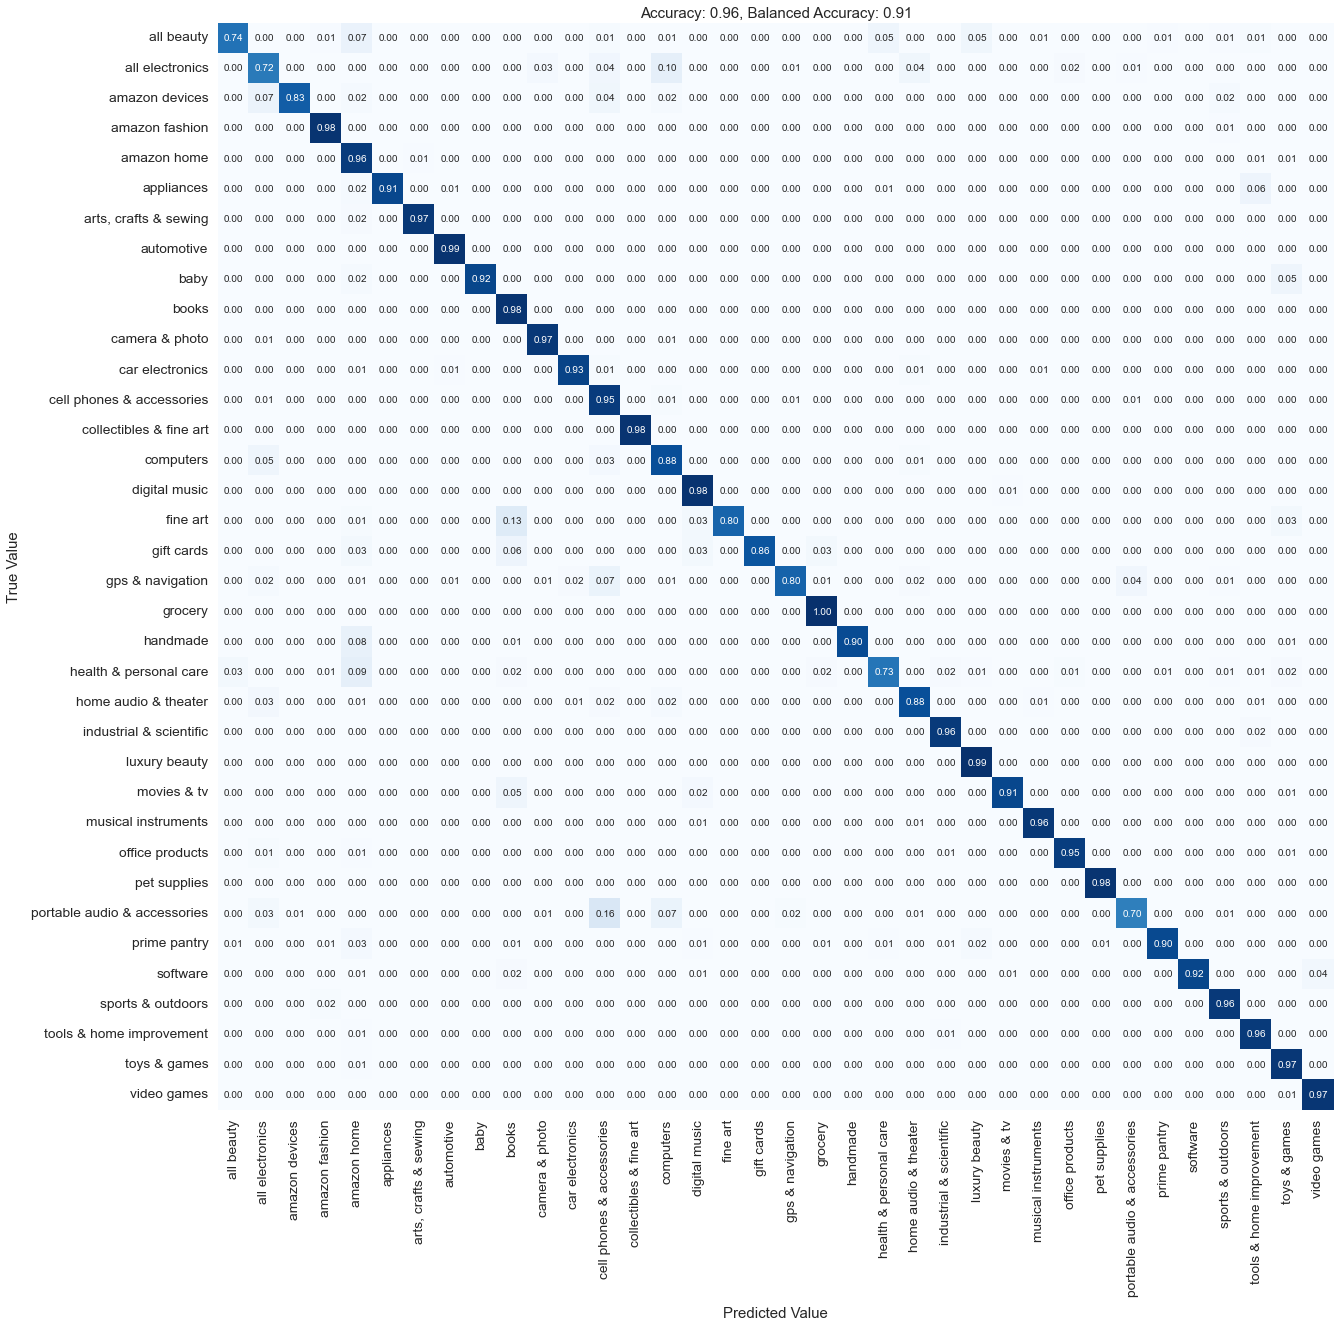

<IPython.core.display.Javascript object>

In [102]:
name = "svm_1"
if name in FIT_MODELS:
    ax = plotting.confusion_matrix(pipe, X_test, y_test, size=(20, 20))
    fig = ax.figure
    joblib.dump(fig, f"figures/{name}.joblib")

else:
    fig = joblib.load(f"figures/{name}.joblib")

fig.savefig(f"figures/{name}.svg", bbox_inches="tight")

Not bad for a baseline! Is it too good to be true, or have my painstaking efforts simply paid off? Let's look at the coefficients.

In [103]:
coef = extract_coef(pipe)
coef.sort_values("all electronics", ascending=False).head(10)

,all beauty,all electronics,amazon devices,amazon fashion,amazon home,appliances,"arts, crafts & sewing",automotive,baby,books,...,musical instruments,office products,pet supplies,portable audio & accessories,prime pantry,software,sports & outdoors,tools & home improvement,toys & games,video games
riorand,-0.049806,1.548995,0.000000,-0.003113,-0.106880,-0.004528,0.000000,-0.031128,-0.017121,0.000000,...,-0.017787,-0.003113,-0.040911,-0.013282,-0.010895,-0.012451,-0.013697,-0.145268,-0.103763,-0.034241
kenable,0.000000,1.093716,-0.003113,-0.009339,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.083600,0.000000,0.000000,-0.009132,0.000000,0.000000,0.000000,-0.024903,-0.020753,0.000000
amscope,0.000000,1.051852,0.000000,0.000000,-0.014527,-0.002264,-0.004669,-0.003113,0.000000,0.000000,...,-0.021345,0.000000,-0.016009,0.000000,-0.004669,-0.006226,-0.022413,-0.019369,-0.009685,0.000000
thermaltake,0.000000,0.970061,0.000000,0.000000,0.000000,-0.011320,0.000000,-0.031128,0.000000,-0.006918,...,0.000000,-0.004669,-0.012451,-0.004981,-0.010895,0.000000,-0.032375,-0.055340,-0.006918,0.000000
silverstone,-0.005534,0.967649,-0.003113,0.000000,-0.012072,0.000000,0.109352,0.001389,0.000000,-0.005534,...,-0.024902,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.015219,-0.009082,0.005158
antec,-0.053957,0.957656,-0.009339,0.000000,-0.017640,0.000000,0.000000,0.000000,0.000000,-0.006918,...,-0.037353,-0.028016,0.000000,0.000000,-0.007782,0.000000,-0.021168,-0.022136,0.000000,0.000000
ocz,0.000000,0.947468,-0.004151,0.000000,0.000000,0.000000,-0.007782,-0.010895,0.000000,0.000000,...,-0.028460,0.000000,0.000000,0.000000,0.000000,-0.004669,-0.026149,0.000000,-0.006918,-0.010895
trendnet,-0.013835,0.939311,-0.012452,0.000000,0.000000,-0.013584,0.000000,0.000000,0.000000,-0.005534,...,-0.003557,0.000000,0.000000,-0.006641,0.000000,-0.009339,0.000000,-0.016602,0.000000,-0.018677
javoedge,-0.002767,0.923899,0.319122,0.000000,-0.010377,0.000000,0.000000,0.000000,0.000000,-0.006918,...,0.000000,-0.003113,-0.024902,-0.067242,0.000000,0.000000,0.000000,0.000000,-0.002767,0.000000
pny,0.000000,0.910901,0.000000,-0.003113,0.000000,0.000000,0.000000,-0.018677,0.000000,0.000000,...,0.000000,-0.026185,0.000000,-0.008302,0.000000,-0.077821,-0.022413,0.000000,0.000000,-0.071595


<IPython.core.display.Javascript object>

The coefficients look just as I expected. Brand terms are at the top, at least for 'all electronics'. While I did filter out only the top 1% of brands for each category, there are still nearly 10,000 brands in the dataset. Moreover, these brand names are recognizable and make sense.

Next, it's time to choose the loss function.

## Selecting the Classifier

I try out all four of the classification loss functions: 'hinge', 'squared_hinge', 'log', and 'modified_huber'. I also tune the penalty and regularization strength, as well as the basic vectorizer settings.

In [104]:
sgd_grid = {
    "cls__loss": ["hinge", "squared_hinge", "log", "modified_huber"],
    "cls__penalty": ["l1", "l2"],
    "cls__alpha": sp.stats.loguniform(1e-8, 1.0),
    "vec__use_idf": [True, False],
    "vec__binary": [True, False],
    "vec__norm": ["l1", "l2", None],
}

sgd_grid

{'cls__loss': ['hinge', 'squared_hinge', 'log', 'modified_huber'],
 'cls__penalty': ['l1', 'l2'],
 'cls__alpha': <scipy.stats._distn_infrastructure.rv_frozen at 0x27fb565ca00>,
 'vec__use_idf': [True, False],
 'vec__binary': [True, False],
 'vec__norm': ['l1', 'l2', None]}

<IPython.core.display.Javascript object>

Given the size of the dataset, with `X_train` at around 800K samples, I opt for a randomized search with successive halving. It's essentially a survival-of-the-fittest contest between a set of randomly-selected parameter combinations. In the first round, the parameters are tested on 10K samples. With each successive round, the weak combinations are eliminated and the amount of data increases.

It's a more scalable approach than running an exhaustive search on the full `X_train`, though it still takes an hour or two. Note that I am optimizing **accuracy** while keeping an eye on "balanced accuracy" a.k.a. macro average (unweighted) recall. I'm mostly concerned with the overall ratio of correct classification, as long as the small classes are reasonably accommodated.

In [105]:
if "loss" in RUN_SWEEPS:
    gs = selection.sweep(
        pipe,
        sgd_grid,
        X=X_train,
        y=y_train,
        cv_dst="sweeps/loss_cv.joblib",
        kind="hrand",
        min_resources=10 ** 4,
        max_resources=X_train.shape[0],
        n_jobs=-1,
        factor=3,
    )
    loss_results = gs.cv_results_
else:
    loss_results = joblib.load("sweeps/loss_cv.joblib")

loss_results = selection.prune_cv(loss_results)
loss_results.head(10)

,alpha,loss,penalty,binary,norm,use_idf,params,mean_fit_time,mean_score,rank_score
0,5.255038e-07,hinge,l2,True,l2,True,"{'cls__alpha': 5.25503769545935e-07, 'cls__los...",241.589407,0.963798,1
1,5.255038e-07,hinge,l2,True,l2,True,"{'cls__alpha': 5.25503769545935e-07, 'cls__los...",121.395599,0.953789,2
2,7.157636e-07,log,l2,False,l2,True,"{'cls__alpha': 7.15763577656479e-07, 'cls__los...",102.892204,0.949059,3
3,1.605315e-08,log,l2,False,l1,True,"{'cls__alpha': 1.6053147327650663e-08, 'cls__l...",99.634805,0.947215,4
4,7.157636e-07,log,l2,False,l2,True,"{'cls__alpha': 7.15763577656479e-07, 'cls__los...",26.191196,0.935344,5
5,5.255038e-07,hinge,l2,True,l2,True,"{'cls__alpha': 5.25503769545935e-07, 'cls__los...",26.031597,0.933922,6
6,1.605315e-08,log,l2,False,l1,True,"{'cls__alpha': 1.6053147327650663e-08, 'cls__l...",28.755394,0.933267,7
7,3.082426e-06,hinge,l2,False,l2,False,"{'cls__alpha': 3.0824261182174037e-06, 'cls__l...",24.616992,0.928700,8
8,7.857063e-06,hinge,l2,False,l2,False,"{'cls__alpha': 7.857063428799315e-06, 'cls__lo...",23.931392,0.924689,9
9,4.430582e-08,log,l2,True,l1,True,"{'cls__alpha': 4.4305817166390654e-08, 'cls__l...",27.540397,0.924622,10


<IPython.core.display.Javascript object>

The default hinge loss wins, with logistic regression in a close second. L2 penalty looks to have completely dominated L1, and the top-scoring 'alpha' values are on the order of $10^7$ or $10^8$. Unsurprisingly, the vector normalization was selected (L2) and IDF weighting to reduce the impact of common terms. Binary occurrence was selected over term-frequency, which I wouldn't have predicted.

For each document and each term, the vectorizer will mark whether the term occurs in that document. Then the vectorizer will apply IDF (inverse document frequency) weighting to the binary features, placing weight on rare terms and withholding it from common ones. Then, finally, it will normalize the vectors to reduce the effect of document length (longer documents typically have a wider variety of terms, meaning more 1s in their vectors).

## Fitting a Linear SVM

The next step is to set the new parameters and fit the second version of the model.

In [106]:
loss_params = loss_results.loc[0, "params"]
display(loss_params)
pipe.set_params(**loss_params)

{'cls__alpha': 5.25503769545935e-07,
 'cls__loss': 'hinge',
 'cls__penalty': 'l2',
 'vec__binary': True,
 'vec__norm': 'l2',
 'vec__use_idf': True}

Pipeline(steps=[('vec',
                 TfidfVectorizer(binary=True, lowercase=False,
                                 token_pattern='(?i)\\b[a-z_]{2,}\\b')),
                ('cls',
                 SGDClassifier(alpha=5.25503769545935e-07,
                               class_weight='balanced', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

In [107]:
if "svm_2" in FIT_MODELS:
    pipe.fit(X_train, y_train)
    joblib.dump(pipe, "models/svm_2.joblib", compress=True)

else:
    pipe = joblib.load("models/svm_2.joblib")
pipe

[Pipeline] ............... (step 1 of 2) Processing vec, total= 1.2min
[Pipeline] ............... (step 2 of 2) Processing cls, total=  39.0s


Pipeline(steps=[('vec',
                 TfidfVectorizer(binary=True, lowercase=False,
                                 token_pattern='(?i)\\b[a-z_]{2,}\\b')),
                ('cls',
                 SGDClassifier(alpha=5.25503769545935e-07,
                               class_weight='balanced', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

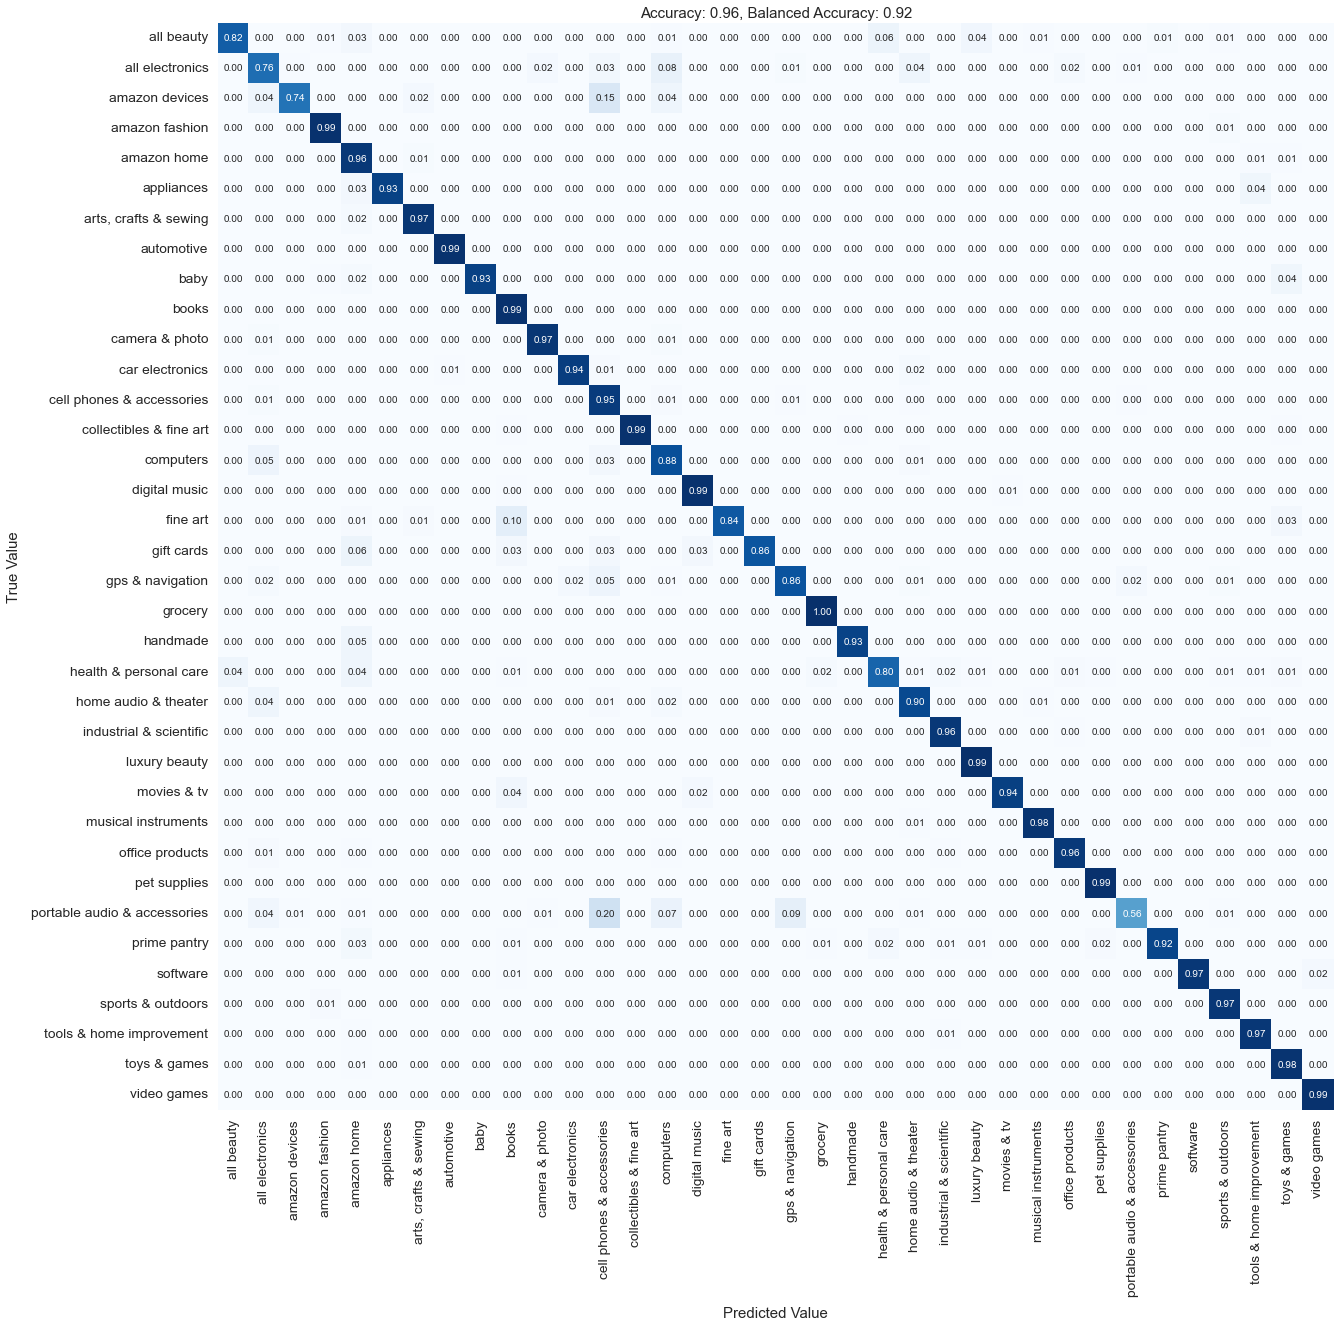

<IPython.core.display.Javascript object>

In [108]:
name = "svm_2"
if name in FIT_MODELS:
    ax = plotting.confusion_matrix(pipe, X_test, y_test, size=(20, 20))
    fig = ax.figure
    joblib.dump(fig, f"figures/{name}.joblib")

else:
    fig = joblib.load(f"figures/{name}.joblib")

fig.savefig(f"figures/{name}.svg", bbox_inches="tight")

It looks like 'amazon devices' and 'portable audio & accessories' have the lowest recall. Amazon doesn't need this classifier for it's own proprietary devices, but 'portable audio' could be better. It's confused with 'cell phones & accessories' about 14% of the time.

Anyway, my focus is on overall accuracy, and I'm not interested in boosting the recall of small classes at the expense of large ones.

In [109]:
coef = extract_coef(pipe)
coef.sort_values("video games", ascending=False).head(10)

,all beauty,all electronics,amazon devices,amazon fashion,amazon home,appliances,"arts, crafts & sewing",automotive,baby,books,...,musical instruments,office products,pet supplies,portable audio & accessories,prime pantry,software,sports & outdoors,tools & home improvement,toys & games,video games
cta_digital,0.000000,-1.518556,-0.227285,-0.138031,-0.728429,0.0,0.000000,-0.483627,0.000000,0.000000,...,-0.701798,-0.097926,-0.188349,-0.062911,0.000000,0.000000,-1.927770,-0.239801,-0.485961,11.015227
electronic_arts,-0.024733,-0.490858,0.000000,-0.131236,-0.549951,0.0,0.000000,-0.236060,0.000000,-2.354016,...,-0.046656,-0.156052,-0.516073,0.000000,-0.025912,-2.412645,-1.957097,-0.194811,-4.127197,9.810335
ubisoft,0.000000,-0.452540,0.000000,-0.250014,-0.282888,0.0,-0.059479,-0.215157,0.000000,-2.131213,...,-0.228126,-0.213823,-0.223994,0.000000,-0.085604,-2.578512,-0.978968,-0.093421,-2.610890,9.447795
mad_catz,0.000000,-2.048554,-0.042683,0.000000,-0.225423,0.0,0.000000,0.000000,-0.058348,-0.055294,...,-2.089125,-0.120688,0.000000,-0.065673,0.000000,-0.083766,-1.336604,-0.119558,-0.588099,9.384804
activision,0.000000,-0.276874,-0.093063,-0.152931,-0.128190,0.0,-0.062662,-0.127217,-0.035952,-2.148903,...,-0.483481,-0.094118,-0.516567,-0.015053,0.000000,-1.678663,-2.074862,-0.315652,-3.797311,9.368181
nintendo,-0.273909,-1.311898,-1.466212,-0.338095,-0.467438,0.0,-0.239796,-0.397644,-0.143202,-1.544156,...,-0.419950,-0.663224,-0.318434,-0.488268,-0.035040,-1.228778,-1.741630,-0.167332,-3.472128,8.962160
atari,-0.031541,-0.378667,0.000000,-0.055170,-0.110064,0.0,-0.056062,-0.277418,0.000000,-1.532794,...,-0.212597,-0.084725,0.000000,0.000000,0.000000,-1.964754,-1.004621,-0.077900,-3.012579,8.812643
sega,0.000000,-0.494302,0.000000,-0.047199,-0.091728,0.0,-0.110345,0.047343,0.000000,-1.489341,...,-0.041520,-0.164350,-0.061834,0.000000,0.000000,-0.509257,-1.259479,-0.010250,-2.293200,8.461054
thq,-0.025982,-0.200353,0.000000,0.000000,0.000000,0.0,0.000000,-0.346070,0.000000,-1.896926,...,-0.251262,-0.123353,-0.713653,0.000000,0.000000,-0.690574,-0.621979,0.174817,-3.436249,8.007886
alawar_entertainment,0.000000,-0.067428,0.000000,0.000000,-0.796663,0.0,0.000000,-0.067139,0.000000,-2.030434,...,-0.067407,-0.121693,0.000000,0.000000,0.000000,-2.445532,-0.554939,-0.053211,-1.020938,6.895922


<IPython.core.display.Javascript object>

Another successful coefficient sanity check. Nearly all of the top features for video games are recognizable brand names.

## Optimizing the Learning Rate

Next I'll optimize the learning rate for stochastic gradient descent. The default is 'optimal', which is a function of $\alpha$, the current time step $t$, and a heuristic value $t_0$.

The other options I'll try are 'constant' and 'adaptive'. As the name suggests, 'constant' is just the constant $eta_0$, which is passed as a hyperparameter. For 'adaptive', the initial learning rate is $eta_0$, but when the stopping criterion is reached, the learning rate is divided by 5 and the descent continues (defying the gods). The descent doesn't stop until the learning rate goes below $10^{-6}$.

In [110]:
learn_grid = [
    {
        "learning_rate": ["constant", "adaptive"],
        "eta0": sp.stats.loguniform(1e-4, 1e4),
        "average": [True, False],
    },
    {
        "learning_rate": ["optimal"],
        "average": [True, False],
    },
]
learn_grid

[{'learning_rate': ['constant', 'adaptive'],
  'eta0': <scipy.stats._distn_infrastructure.rv_frozen at 0x27a085a5250>,
  'average': [True, False]},
 {'learning_rate': ['optimal'], 'average': [True, False]}]

<IPython.core.display.Javascript object>

In [111]:
if "learn" in RUN_SWEEPS:
    gs = selection.sweep(
        pipe,
        learn_grid,
        X=X_train,
        y=y_train,
        cv_dst="sweeps/learn_cv.joblib",
        kind="hrand",
        add_prefix="cls__",
        min_resources=10 ** 4,
        max_resources=X_train.shape[0],
        n_jobs=-1,
        factor=3,
    )
    learn_results = gs.cv_results_
else:
    learn_results = joblib.load("sweeps/learn_cv.joblib")

learn_results = selection.prune_cv(learn_results)
learn_results.head(10)

,average,eta0,learning_rate,params,mean_fit_time,mean_score,rank_score
0,True,0.841666,adaptive,"{'cls__average': True, 'cls__eta0': 0.84166636...",2718.412539,0.964341,1
1,True,0.841666,adaptive,"{'cls__average': True, 'cls__eta0': 0.84166636...",971.841199,0.954659,2
2,False,1.656650,adaptive,"{'cls__average': False, 'cls__eta0': 1.6566501...",362.309605,0.954233,3
3,False,0.857235,constant,"{'cls__average': False, 'cls__eta0': 0.8572352...",85.645006,0.952689,4
4,True,0.841666,adaptive,"{'cls__average': True, 'cls__eta0': 0.84166636...",289.311396,0.938111,5
5,False,1.656650,adaptive,"{'cls__average': False, 'cls__eta0': 1.6566501...",117.517600,0.937444,6
6,False,0.857235,constant,"{'cls__average': False, 'cls__eta0': 0.8572352...",36.053796,0.937389,7
7,False,1.925135,adaptive,"{'cls__average': False, 'cls__eta0': 1.9251349...",116.465399,0.936867,8
8,False,0.086955,constant,"{'cls__average': False, 'cls__eta0': 0.0869545...",26.184200,0.935878,9
9,False,0.081826,constant,"{'cls__average': False, 'cls__eta0': 0.0818255...",87.510197,0.935878,9


<IPython.core.display.Javascript object>

Looks like 'adaptive' wins, and with an epic fit time. The long fit time makes sense given the unyielding nature of the algorithm.

## Fitting the Final Model

Time to fit the third and final version of the model, now with 'adaptive' learning rate.

In [112]:
learn_params = learn_results.loc[0, "params"]
display(learn_params)
pipe.set_params(**learn_params)

{'cls__average': True,
 'cls__eta0': 0.8416663608926325,
 'cls__learning_rate': 'adaptive'}

Pipeline(steps=[('vec',
                 TfidfVectorizer(binary=True, lowercase=False,
                                 token_pattern='(?i)\\b[a-z_]{2,}\\b')),
                ('cls',
                 SGDClassifier(alpha=5.25503769545935e-07, average=True,
                               class_weight='balanced', eta0=0.8416663608926325,
                               learning_rate='adaptive', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

In [113]:
if "svm_3" in FIT_MODELS:
    pipe.fit(X_train, y_train)

    joblib.dump(pipe, "models/svm_3.joblib", compress=True)

else:
    pipe = joblib.load("models/svm_3.joblib")
pipe

[Pipeline] ............... (step 1 of 2) Processing vec, total= 1.3min
[Pipeline] ............... (step 2 of 2) Processing cls, total=10.5min


Pipeline(steps=[('vec',
                 TfidfVectorizer(binary=True, lowercase=False,
                                 token_pattern='(?i)\\b[a-z_]{2,}\\b')),
                ('cls',
                 SGDClassifier(alpha=5.25503769545935e-07, average=True,
                               class_weight='balanced', eta0=0.8416663608926325,
                               learning_rate='adaptive', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

That took ~10 minutes to train, which is about 5x a long as the 'optimal' learning rate.

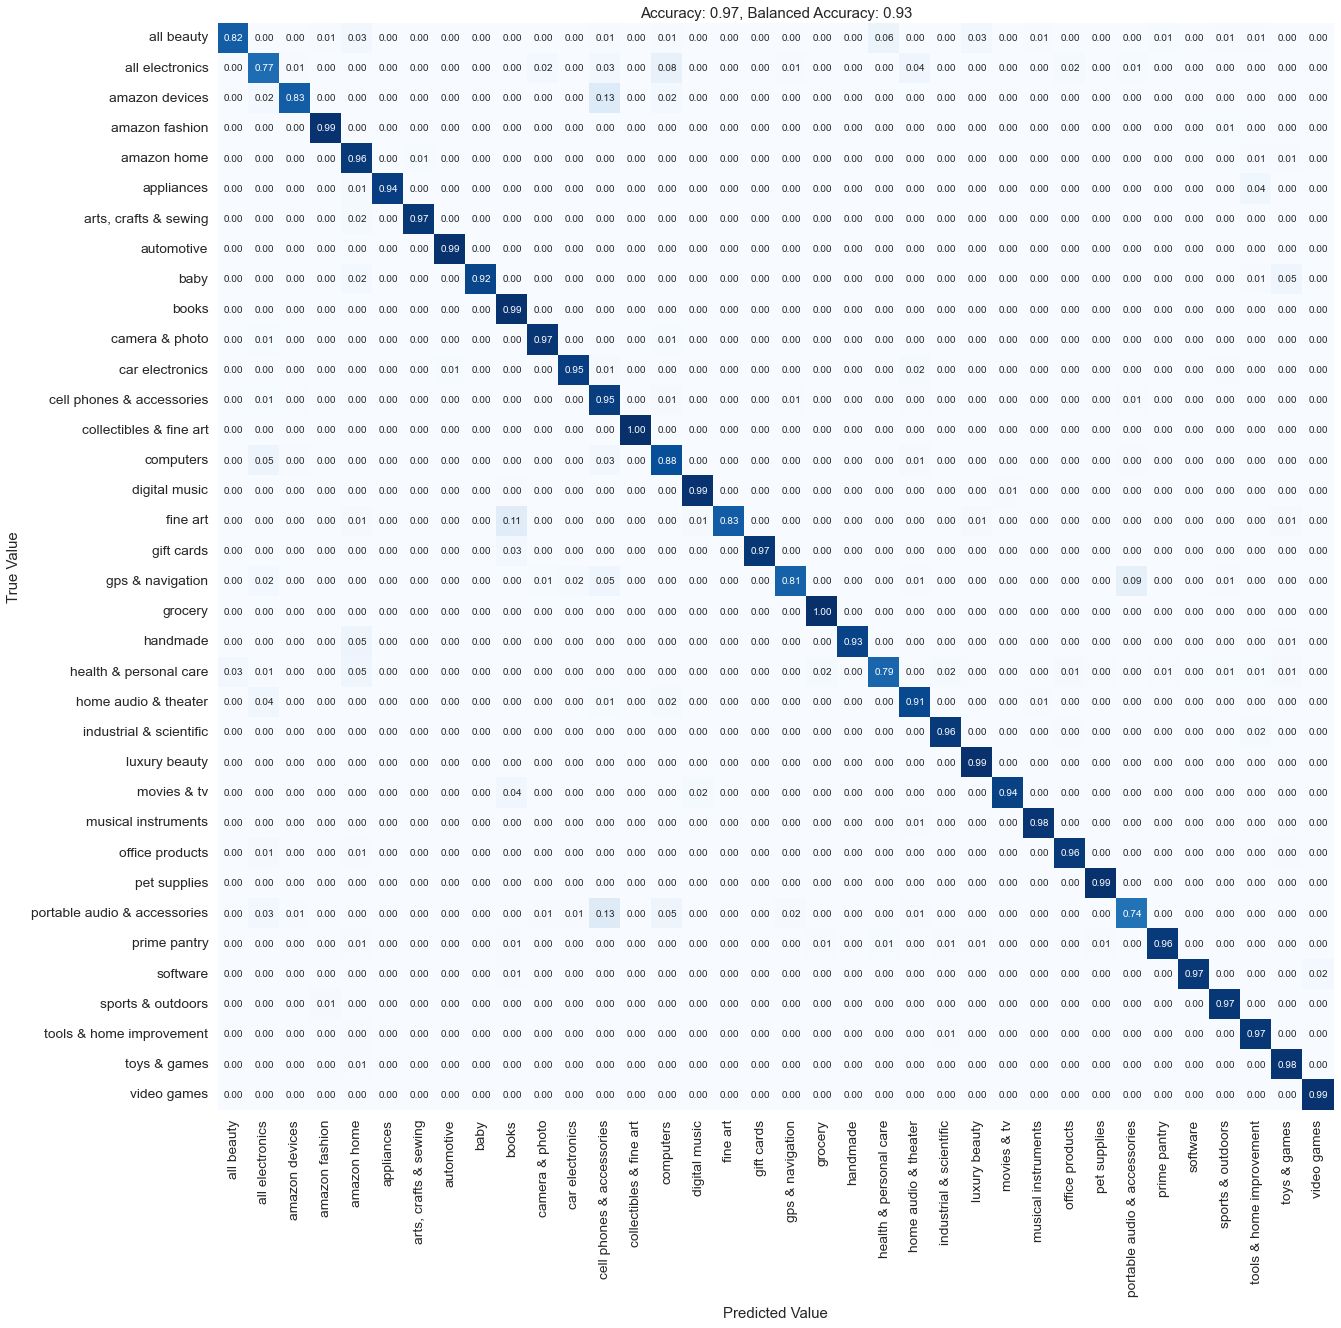

<IPython.core.display.Javascript object>

In [114]:
name = "svm_3"
if name in FIT_MODELS:
    ax = plotting.confusion_matrix(pipe, X_test, y_test, size=(20, 20))
    fig = ax.figure
    joblib.dump(fig, f"figures/{name}.joblib")

else:
    fig = joblib.load(f"figures/{name}.joblib")

fig.savefig(f"figures/{name}.svg", bbox_inches="tight")

It's up to 0.97 accuracy, and the balanced accuracy improved slightly. 0.97 accuracy is quite a satisfactory number, so I'll move on to interpretation.

# Interpreting the Results

The next step is to take a closer look at the final model's coefficients. I already know that brand terms are critically important, but I'd like to see which brands are associated with which categories. I'm also interested in discovering what non-brand terms made it to the top.

In [115]:
coef = extract_coef(pipe)
coef.columns = coef.columns.str.title()
coef.sort_values("Amazon Fashion", ascending=False).head(20)

,All Beauty,All Electronics,Amazon Devices,Amazon Fashion,Amazon Home,Appliances,"Arts, Crafts & Sewing",Automotive,Baby,Books,...,Musical Instruments,Office Products,Pet Supplies,Portable Audio & Accessories,Prime Pantry,Software,Sports & Outdoors,Tools & Home Improvement,Toys & Games,Video Games
package_dimensions,-1.770339,-0.641692,-0.876385,6.494584,-3.843346,-0.081726,-1.548520,-1.538169,-1.883307,-1.400206,...,-0.618648,-0.740660,-0.429460,-0.320153,-0.397067,-0.268902,-4.031144,-0.036984,-4.423113,-0.097266
port_authority,-0.138099,-0.055106,-0.011360,5.787554,-0.204637,-0.047828,-0.157534,-0.069021,-0.070114,-0.093964,...,0.000000,-0.033669,-0.042997,0.000000,0.000000,0.000000,-4.161339,-0.272483,-0.067426,0.000000
product_dimensions,-2.190721,-0.511469,3.279420,5.207410,-0.507705,1.077900,-0.885973,-0.921784,-0.962938,-1.046195,...,-0.218586,-1.370566,-0.517588,0.255762,-0.321508,-0.193689,-3.250779,-0.688798,-3.117347,-0.064233
sk_hat_shop,-0.122827,0.000000,-0.203547,4.582140,-0.393996,0.000000,-0.170929,-0.051005,-0.179703,-0.128450,...,0.000000,-0.085779,-0.010351,0.000000,0.000000,0.000000,-3.130259,-0.003427,-0.819706,0.000000
fun_world,-0.215697,-0.066970,-0.007368,4.524271,-0.909050,0.000000,-0.019456,0.000000,-0.244305,0.006940,...,0.000000,0.058262,-0.384182,0.000000,0.000000,-0.047429,-0.261712,0.000000,-2.200367,0.098568
sport_tek,0.000000,0.000000,0.000000,4.382008,-0.054535,0.000000,-0.074304,-0.120366,0.000000,-0.147895,...,-0.020683,0.000000,0.000000,0.000000,0.000000,0.000000,-3.185457,-0.105739,0.000000,0.000000
clothing_shoes,-0.651826,-0.400833,-0.008426,4.303687,-0.893660,0.000000,-0.385684,-0.044773,-0.399301,-0.682476,...,-0.013904,0.361277,-0.061845,-0.010225,-0.017673,-0.238378,-2.842474,-0.022650,-0.779017,0.000000
creative_ventures_jewelry,-0.354401,0.000000,0.000000,3.872578,-1.289919,0.000000,-0.632973,-0.017453,0.000000,-0.632153,...,-0.014222,0.000000,-0.013487,0.000000,0.000000,0.000000,-0.475815,-0.293679,-0.604158,-0.047837
rubber_sole,-0.361801,-0.287910,-0.155616,3.806286,-0.863268,-0.008171,0.118230,-0.145768,-0.216506,-0.806254,...,-0.139507,-0.113727,0.240057,-0.097692,-0.153922,-0.114314,-2.421803,-0.653098,-0.267036,-0.031103
synthetic_sole,-0.107106,-0.055457,-0.076040,3.756691,-0.534151,-0.011366,-0.221218,-0.192350,-0.570531,-0.435127,...,-0.028005,-0.035326,-0.066740,-0.017669,-0.036173,-0.149087,-1.985086,-0.296592,-0.155019,-0.038516


<IPython.core.display.Javascript object>

I definitely recognize some of these fashion brands, like Harley Davidson.

Since there are 36 categories and ~490K terms, it's difficult to get a view of the big picture. In order to get a birds-eye-view, I'm going to plot a small wordcloud for each of the top 9 categories, measured by $F_1$-score. Then I'll do the same for the bottom 9 categories.

I prepare some colormaps in the following cell.

In [116]:
rng = np.random.default_rng(1594)

cmaps = [
    "Purples",
    "Blues",
    "Greens",
    "Oranges",
    "Reds",
    "YlOrBr",
    "YlOrRd",
    "OrRd",
    "PuRd",
    "RdPu",
    "BuPu",
    "GnBu",
    "PuBu",
    "YlGnBu",
    "PuBuGn",
    "BuGn",
    "YlGn",
]
rng.shuffle(cmaps)
cmaps

['Purples',
 'Greens',
 'BuGn',
 'YlGn',
 'GnBu',
 'RdPu',
 'YlOrRd',
 'BuPu',
 'PuBu',
 'PuRd',
 'Reds',
 'YlGnBu',
 'Oranges',
 'Blues',
 'PuBuGn',
 'OrRd',
 'YlOrBr']

<IPython.core.display.Javascript object>

Next, I get the scores for each category.

In [117]:
report = get_report(pipe)
report.sort_values("f1-score", ascending=False).head()

,precision,recall,f1-score,support
grocery,0.997663,0.997967,0.997815,9839.0
books,0.991488,0.989266,0.990376,27669.0
luxury beauty,0.985629,0.993961,0.989778,1656.0
automotive,0.987663,0.989678,0.988670,16664.0
amazon fashion,0.987020,0.986052,0.986536,27531.0


<IPython.core.display.Javascript object>

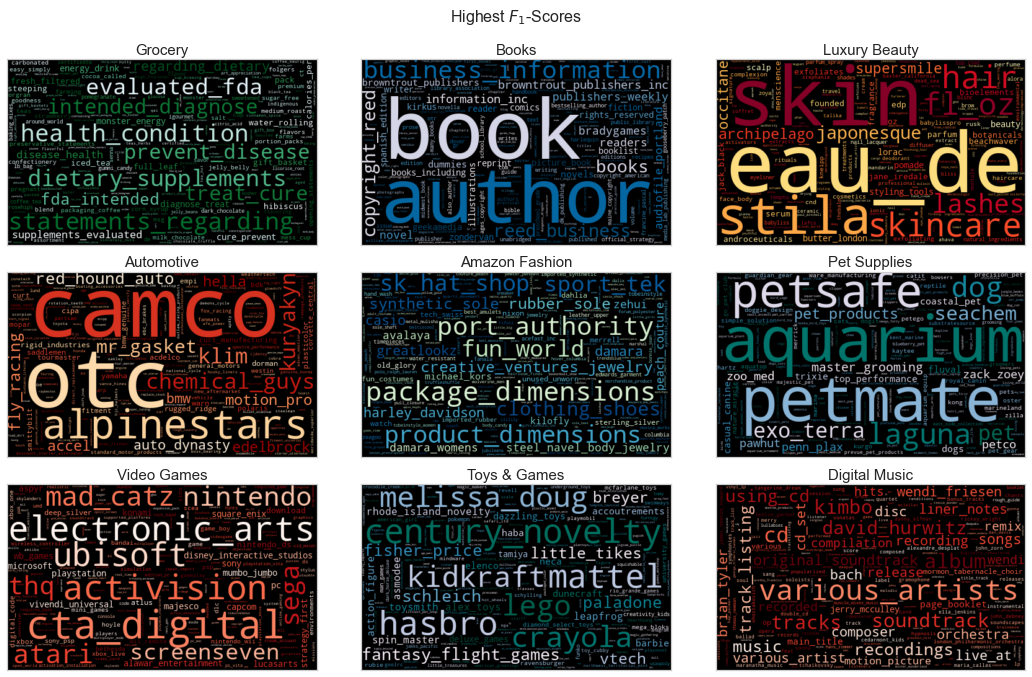

<IPython.core.display.Javascript object>

In [118]:
top_f1 = report["f1-score"].nlargest(9).index.str.title()

fig = plotting.wordcloud(
    coef.loc[:, top_f1],
    cmap=rng.choice(cmaps, 9).tolist(),
)
fig.suptitle("Highest $F_{1}$-Scores", y=1.04, fontsize=16)
fig.savefig("figures/coef_top_f1.svg", bbox_inches="tight")

There are a lot of brand terms at the forefront, as I expected. However, There is also some category-specific fine print that shows up, especially in Grocery and Books. Legalistic phrases like "evaluated_fda", "fda_intended, "copyright_reed", and "rights_reserved" are among the top coefficients for these categories. This is probably because boilerplate category-related legalistic text appears repeatedly throughout the category, but does not appear in other categories.

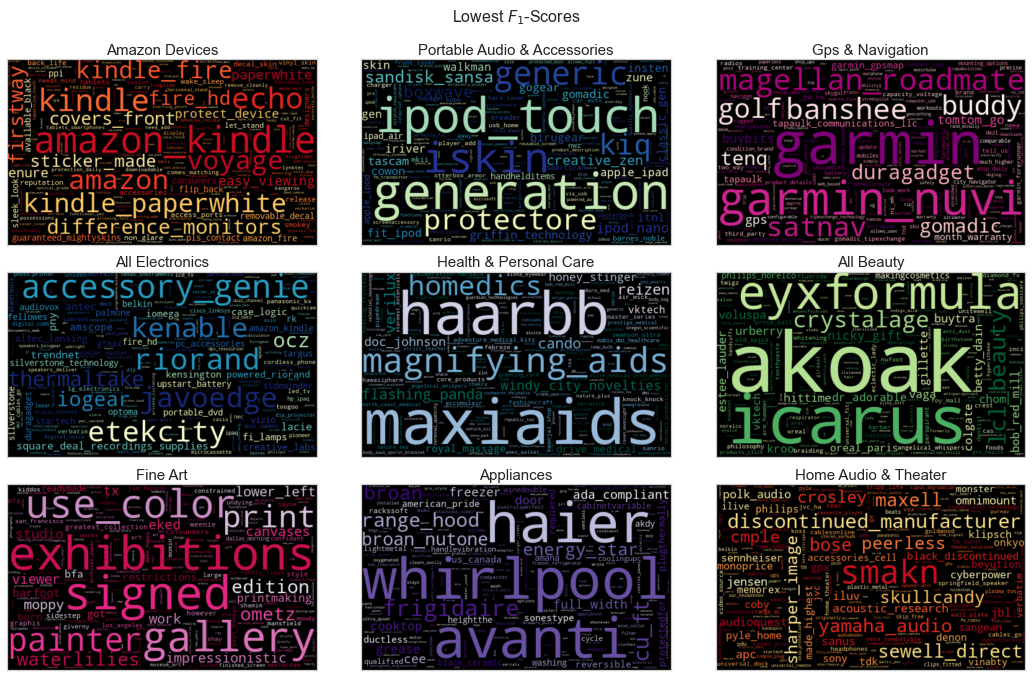

<IPython.core.display.Javascript object>

In [119]:
bottom_f1 = report["f1-score"].nsmallest(9).index.str.title()

fig = plotting.wordcloud(
    coef.loc[:, bottom_f1],
    cmap=rng.choice(cmaps, 9).tolist(),
)
fig.suptitle("Lowest $F_{1}$-Scores", y=1.04, fontsize=16)
fig.savefig("figures/coef_bot_f1.svg", bbox_inches="tight")

Brand names are on top across the board for the categories with the lowest $F_{1}$-scores. The classifier still does pretty well for these categories, as evidenced by the highly recognizable brand names.

# Conclusion

I developed a highly accurate 36-class classifier for Amazon products using tried-and-true machine learning methods. One reason the model attained such a high score is that I selected a very high quality dataset. Amazon product data is both plentiful and well-labeled. The human-given category labels are highly accurate. Why? Because on Amazon, people's livelihoods are on the line (including Amazon's). It matters to sellers how they classify their products, and it matters to you too. Classification matters to businesses because it matters to customers&mdash;it can determine whether a customer buys a product or never even hears about it.

#### If you're looking to classify products with NLP, lead with the brand terms.

Brand terms ranked high in nearly every category. One could build a decent model with *only* brand terms, though I wouldn't recommend going that far. Even if you wanted an image-based classifier, brands are the first place I'd start. 

#### Don’t ignore boilerplate legalistic text, because sometimes it’s category-specific.

In fact, I recommend you gather up all the legalistic caveats and copyright statements you can get. This text is sometimes very distinctive of its category.

#### Use the model to study your competitors and scope out new suppliers.

This model can be used to analyze other business' inventories, including those of competitors. Discover new products and suppliers by directly comparing their inventories to yours under your classification scheme. See how their classification differs from yours by examining how the categories line up.

# Looking Forward

- Gather data on brands concerning their relationships and parent companies.
    - Try to expand the model's coverage to more obscure brands.
- Develop a workflow to create specialized subcategory models for each major category.
    - These will be **multilabel** classification models.
- Create a dashboard to demonstrate the accuracy and rich interpretability of the model.
- Obtain a new, unseen dataset to test the model's generalizability.